## Detecting concepts missing from D_probe

In [ ]:
import os
#virtually move to parent directory
os.chdir("..")

import torch

import utils
import data_utils
import similarity

from matplotlib import pyplot as plt

## Settings

In [2]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'fc'
d_probe = 'cifar100_train'
concept_set = 'data/imagenet_labels.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi
ids_to_check = [131, 132]

## Run CLIP-Dissect

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

100%|██████████| 1000/1000 [00:01<00:00, 738.42it/s]


torch.Size([1000, 1000])
Files already downloaded and verified


## Display results


 Layer:fc Neuron:131
1st description: little blue heron, Egretta caerulea, sim:3.620
2nd description: European gallinule, Porphyrio porphyrio, sim:2.699
3rd description: African grey, African gray, Psittacus erithacus, sim:2.477
5 most highly activating images in D_probe:


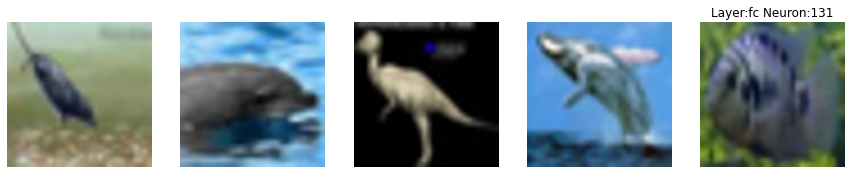


 Layer:fc Neuron:132
1st description: American egret, great white heron, Egretta albus, sim:3.228
2nd description: little blue heron, Egretta caerulea, sim:2.509
3rd description: spoonbill, sim:2.437
5 most highly activating images in D_probe:


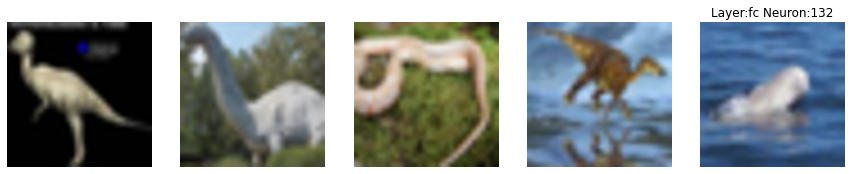

In [5]:
ranks = ["1st", "2nd", "3rd"]
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

for orig_id in ids_to_check:

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))
    
    print("5 most highly activating images in D_probe:")
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()